# Testis Cell Selection

In [32]:
import os
import sys
from pathlib import Path
from glob import glob

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb, Seurat
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.cell_selection import cellranger_counts, plot_barcode_rank, filter_gene_counts_by_barcode
from larval_gonad.bulk import read_bulk, TESTIS_BULK, plot_bulk_pairwise_corr, scRNAseq_corr_distribution, plot_corr_distribution

# Setup notebook
nbconfig = Nb.setup_notebook('01.01-testis_cell_selection', '../output/testis_cell_selection', fig_dir='figures')
mpl.style.use(['common', 'notebook'])

last updated: 2018-03-28 
Git hash: fd4bbba44352ed860ddf0d51ee1903603d7e2dff


The first step in the analysis is selecting what is a cell and what is background. Along with our single cell data we created bulk RNA-seq libraries with samples that were processed similarly. To estimate a cutoff to use for cell selection we compare the total scRNA-seq expression summed across cells with the bulk RNA-Seq expression. We will include the total number of cells that gives us a maximum correlation with Bulk data. With the idea that as we add cells with low UMI the correlation will worsen if they are infact debris.

Below I plot the Spearman's r for each scRNA-Seq sample (1, 2, and 3) with each of the four replicates of bulk RNA-seq data (B5_TCP, B6_TCP, B7_TCP, B8_TCP). As we add more UMI sorted cells Spearman's R increases to a peak. Testis sample 1 behaves differently than samples 2 and 3. For now I am going to focus on samples 2 and 3 because they have the expected behavior of peaking around 1,200 cells. 

In [2]:
# Get single cell data ready
umi1 = pd.read_parquet('../output/testis1/larval_umi.parquet').sort_values('umi_count', ascending=False)
raw1 = cellranger_counts('../output/testis1/outs/raw_gene_bc_matrices_h5.h5')

umi2 = pd.read_parquet('../output/testis2/larval_umi.parquet').sort_values('umi_count', ascending=False)
raw2 = cellranger_counts('../output/testis2/outs/raw_gene_bc_matrices_h5.h5')

umi3 = pd.read_parquet('../output/testis3/larval_umi.parquet').sort_values('umi_count', ascending=False)
raw3 = cellranger_counts('../output/testis3/outs/raw_gene_bc_matrices_h5.h5')

# Import testis bulk data.
bulk_dat = read_bulk('../bulk-rnaseq-wf/data/rnaseq_samples', filter=TESTIS_BULK)

In [24]:
# Calculate Correlations with bulk data
corr1 = scRNAseq_corr_distribution(umi1, raw1, bulk_dat)
corr2 = scRNAseq_corr_distribution(umi2, raw2, bulk_dat)
corr3 = scRNAseq_corr_distribution(umi3, raw3, bulk_dat)

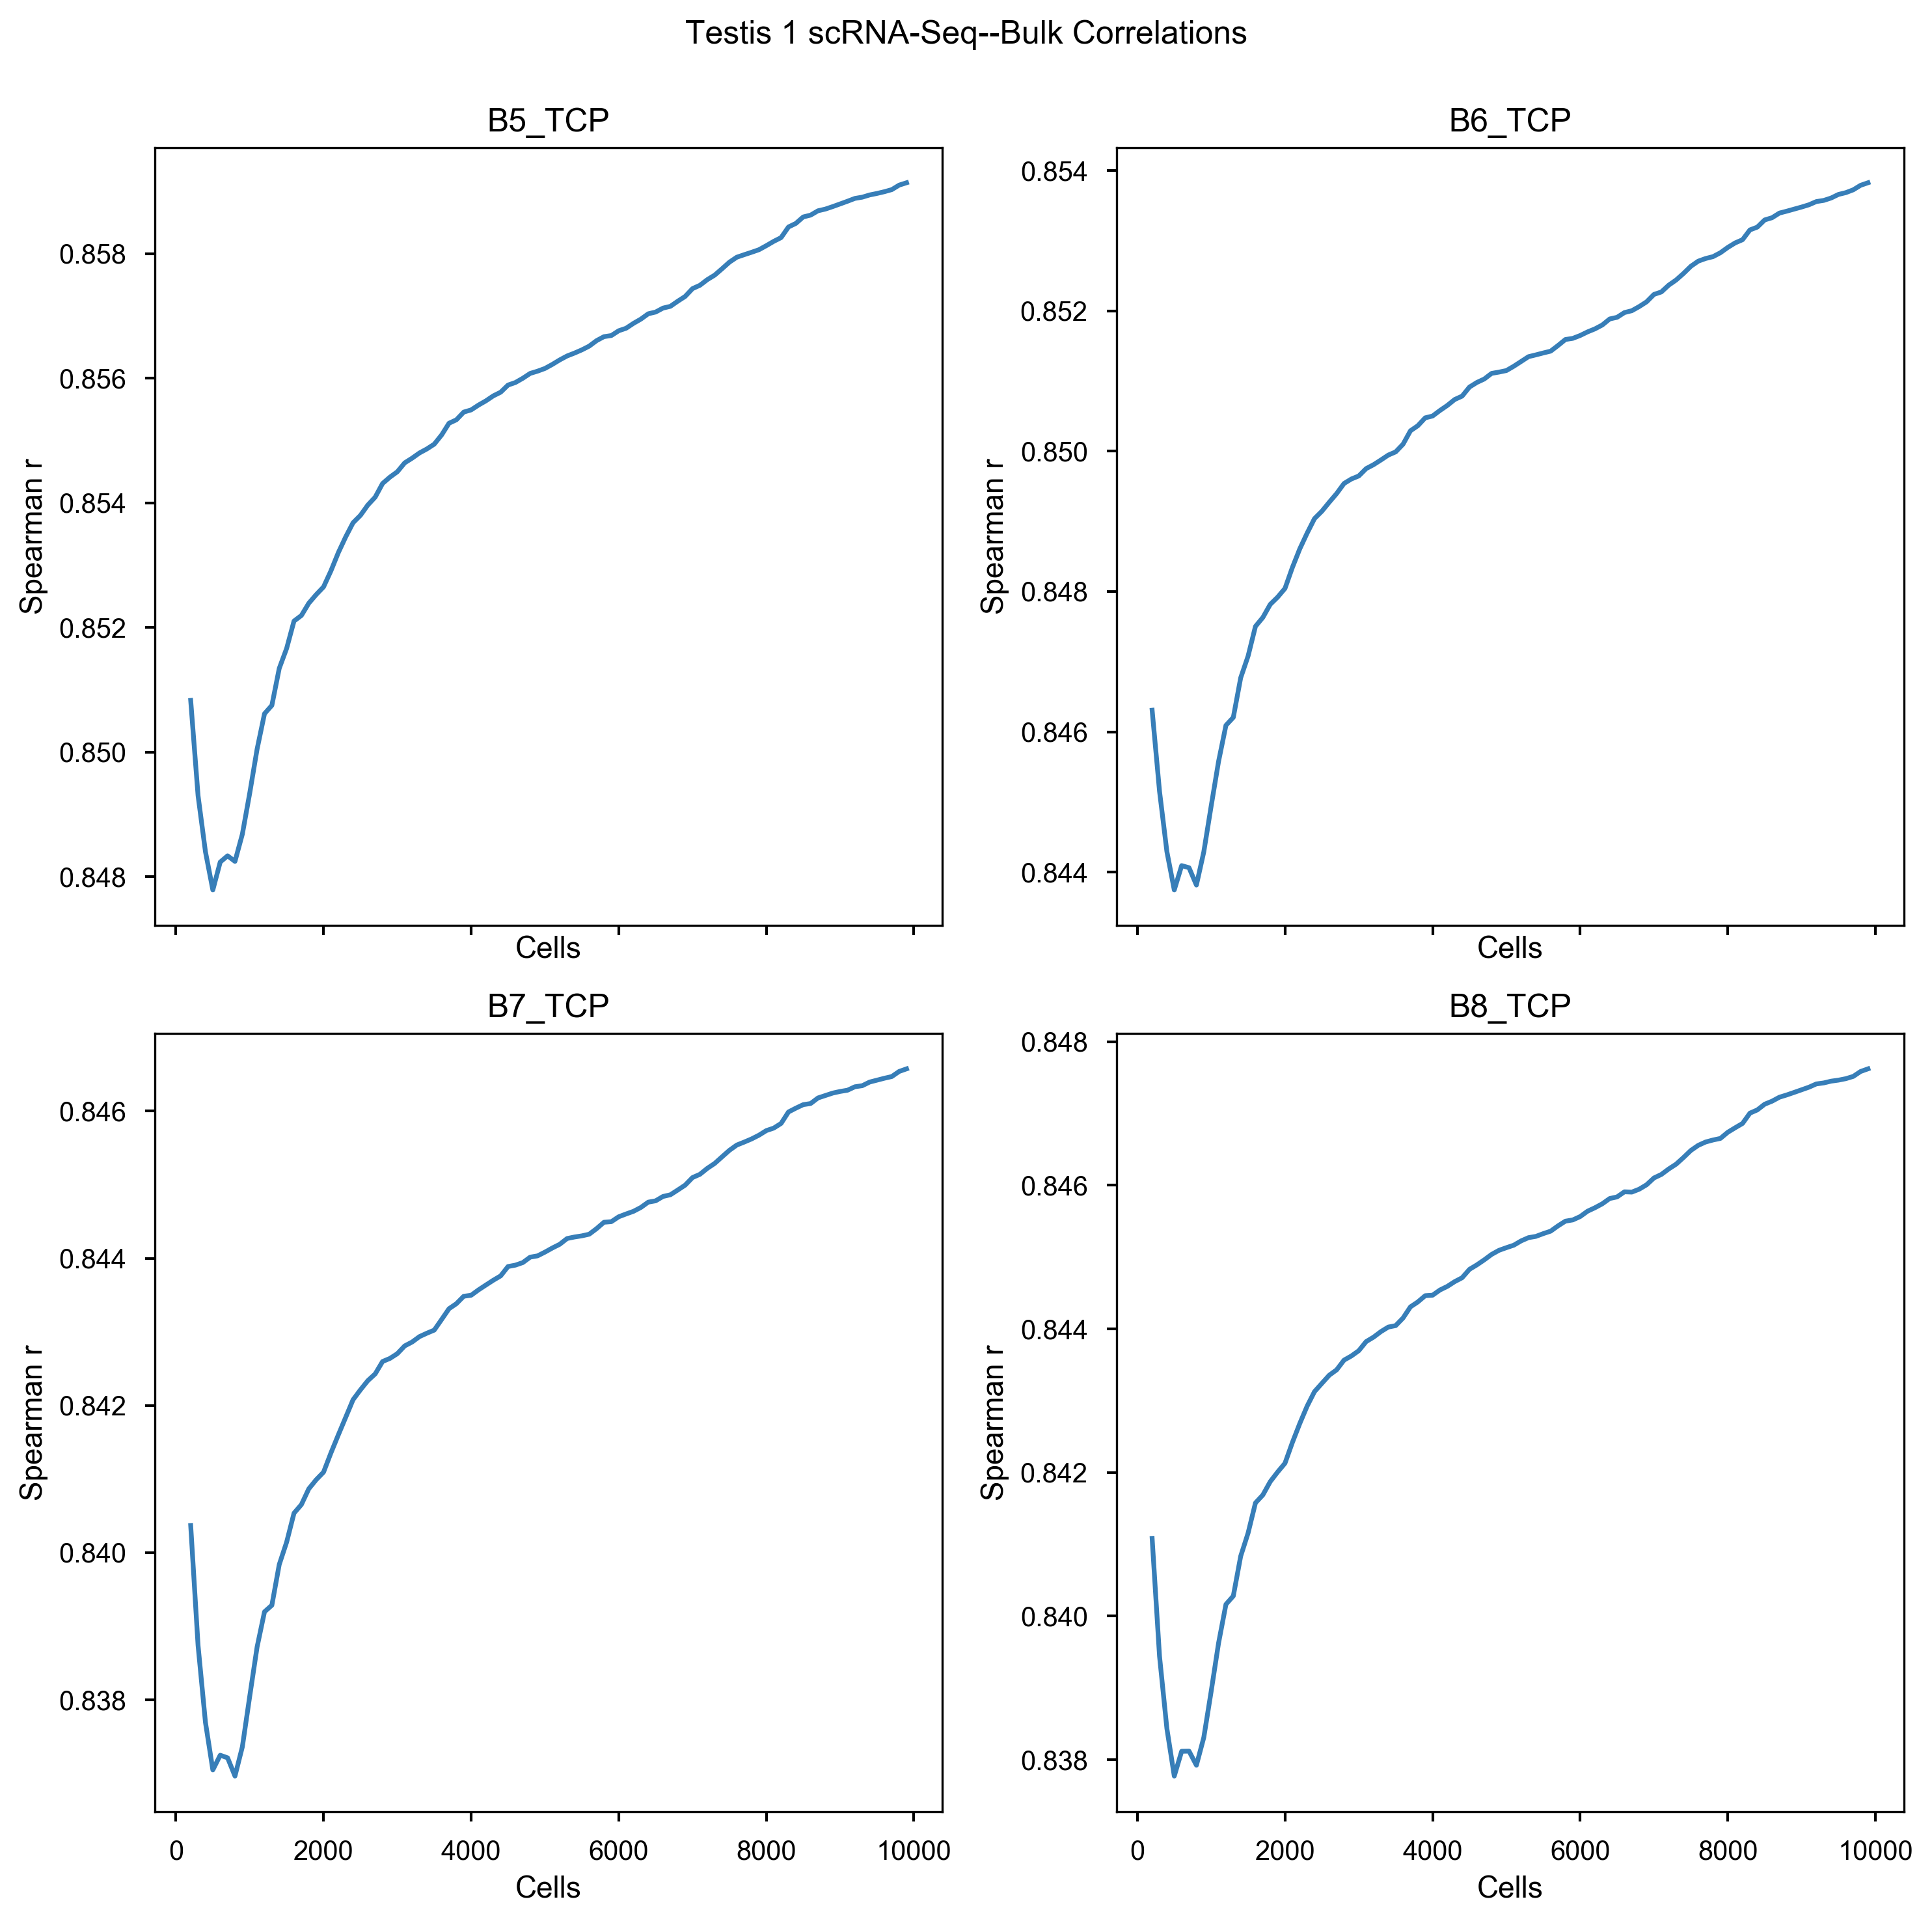

In [33]:
@make_figs(nbconfig.fig_name('testis1_bulk_corr'), styles=nbconfig.styles_full, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .95]})
def _plot():
    plot_corr_distribution(corr1)
    plt.suptitle('Testis 1 scRNA-Seq--Bulk Correlations')
_plot()

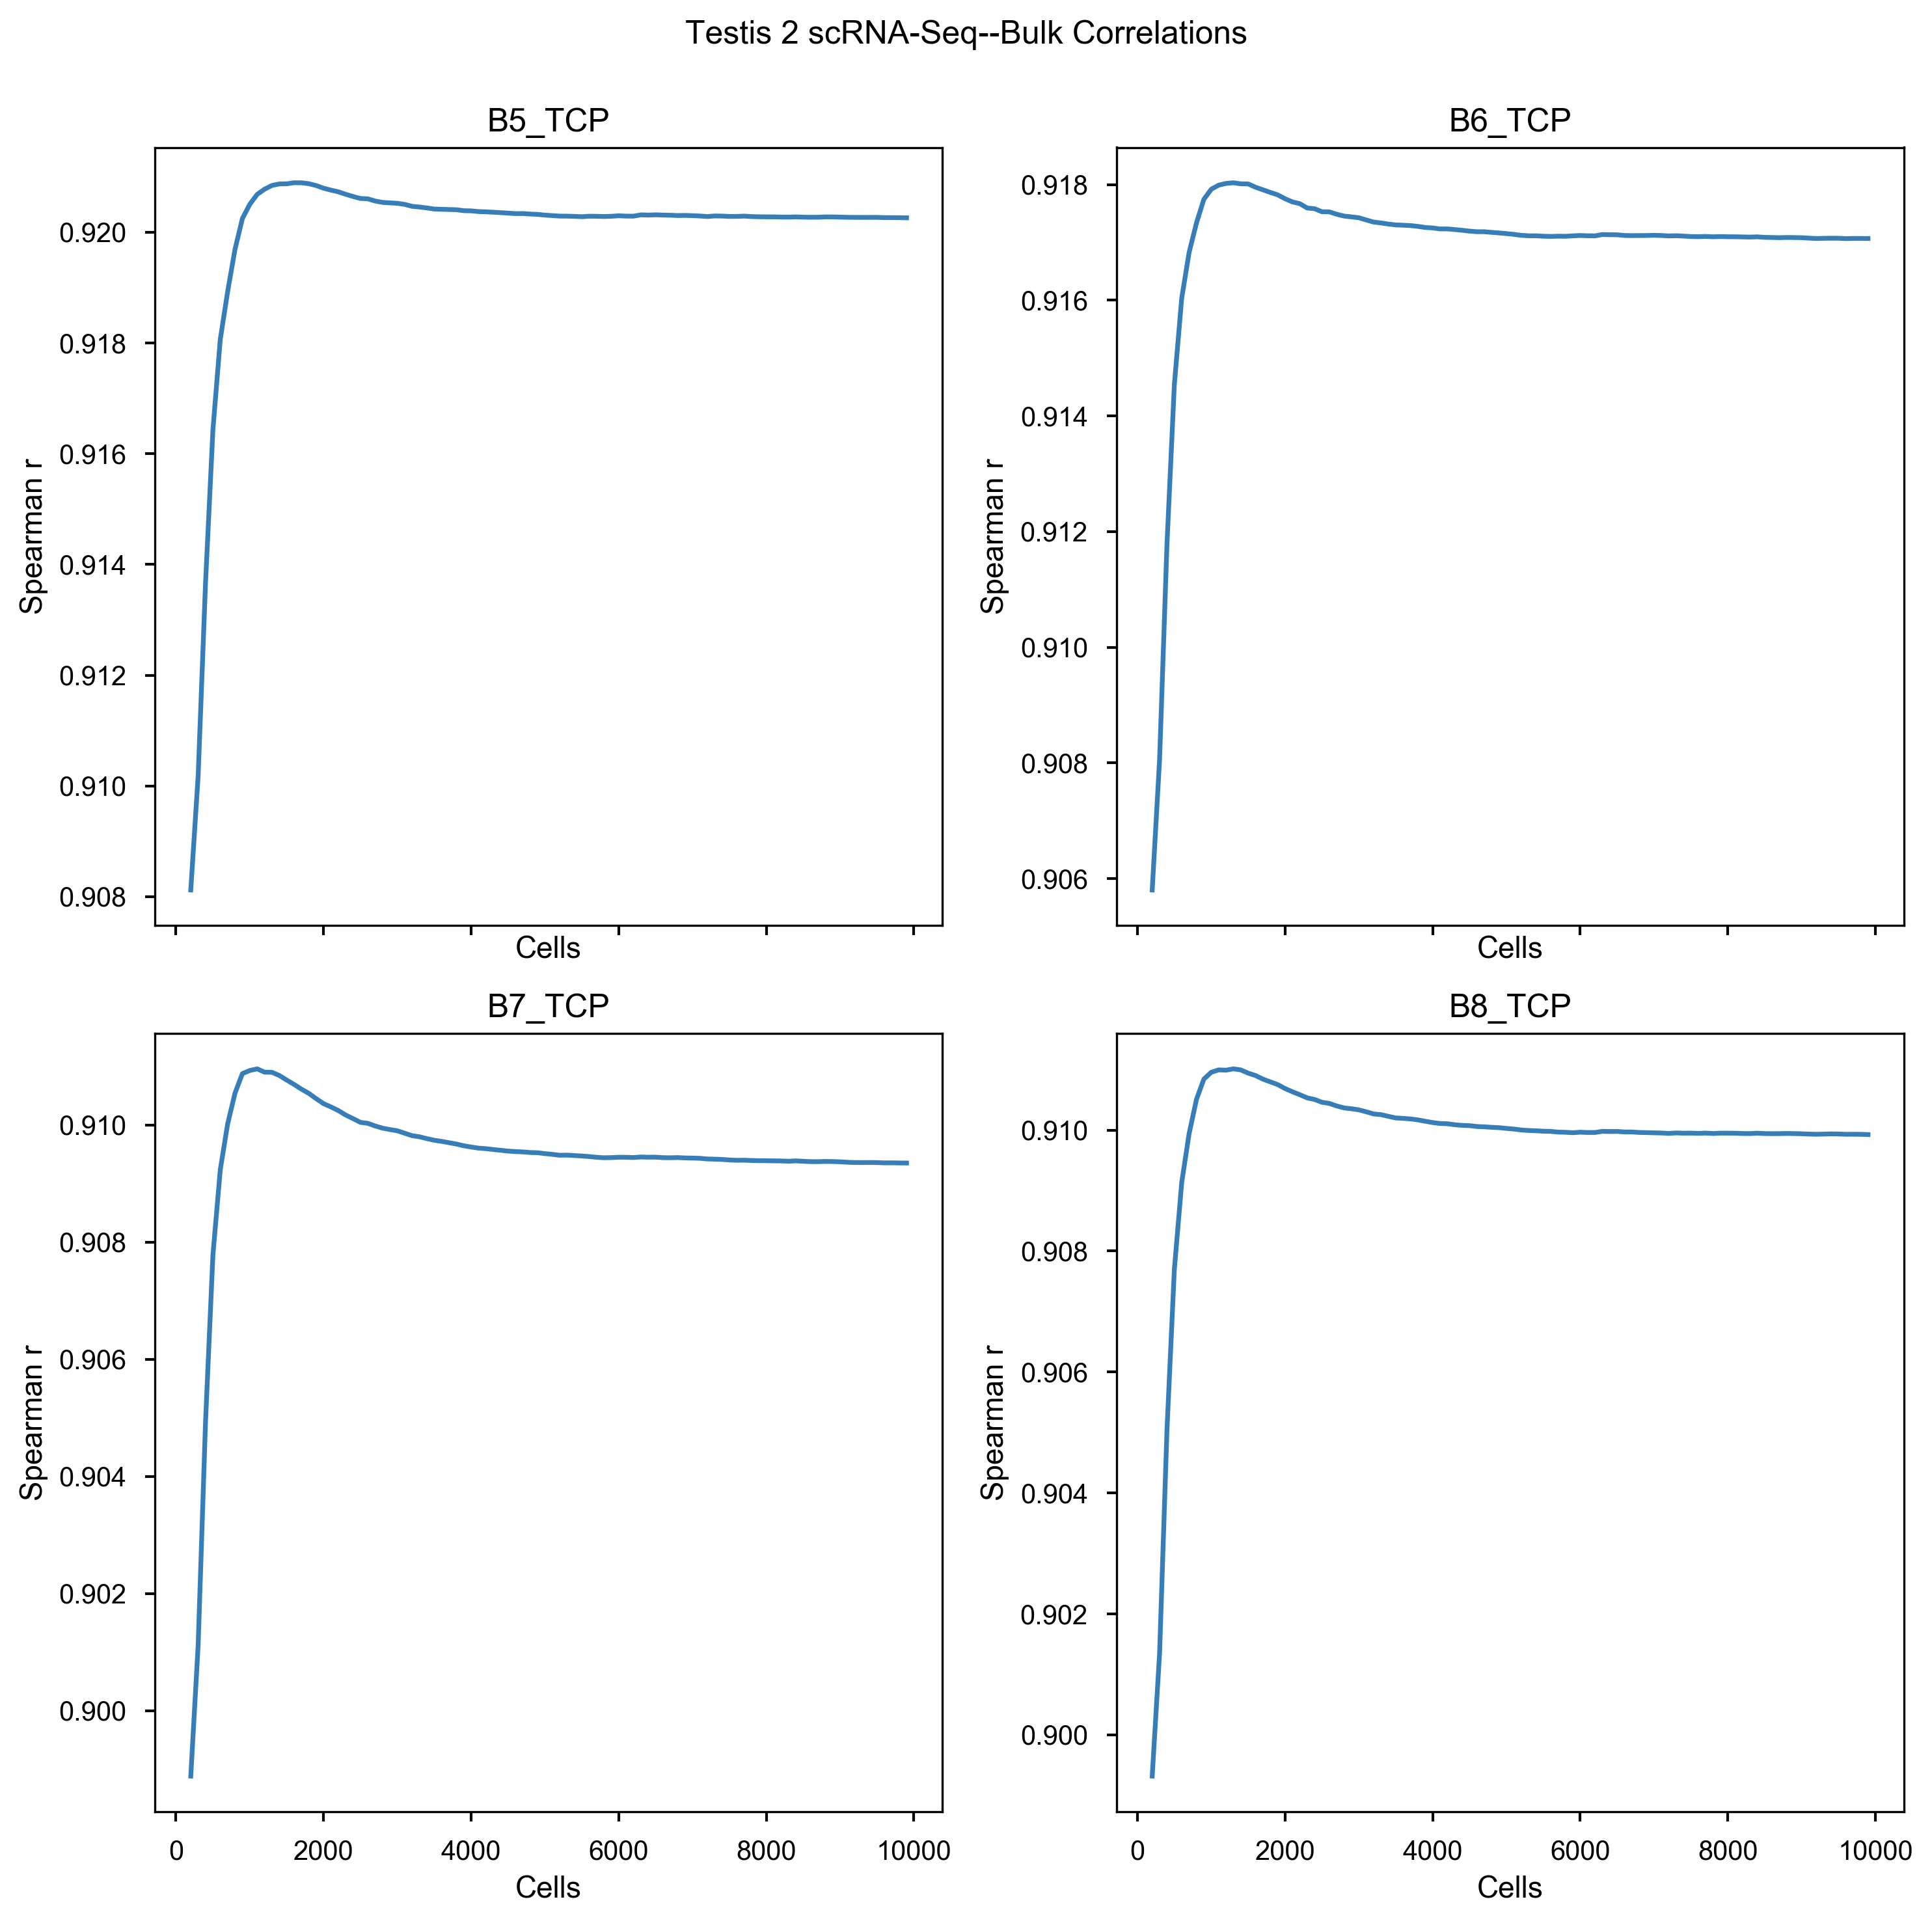

In [34]:
@make_figs(nbconfig.fig_name('testis2_bulk_corr'), styles=nbconfig.styles_full, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .95]})
def _plot():
    plot_corr_distribution(corr2)
    plt.suptitle('Testis 2 scRNA-Seq--Bulk Correlations')
_plot()

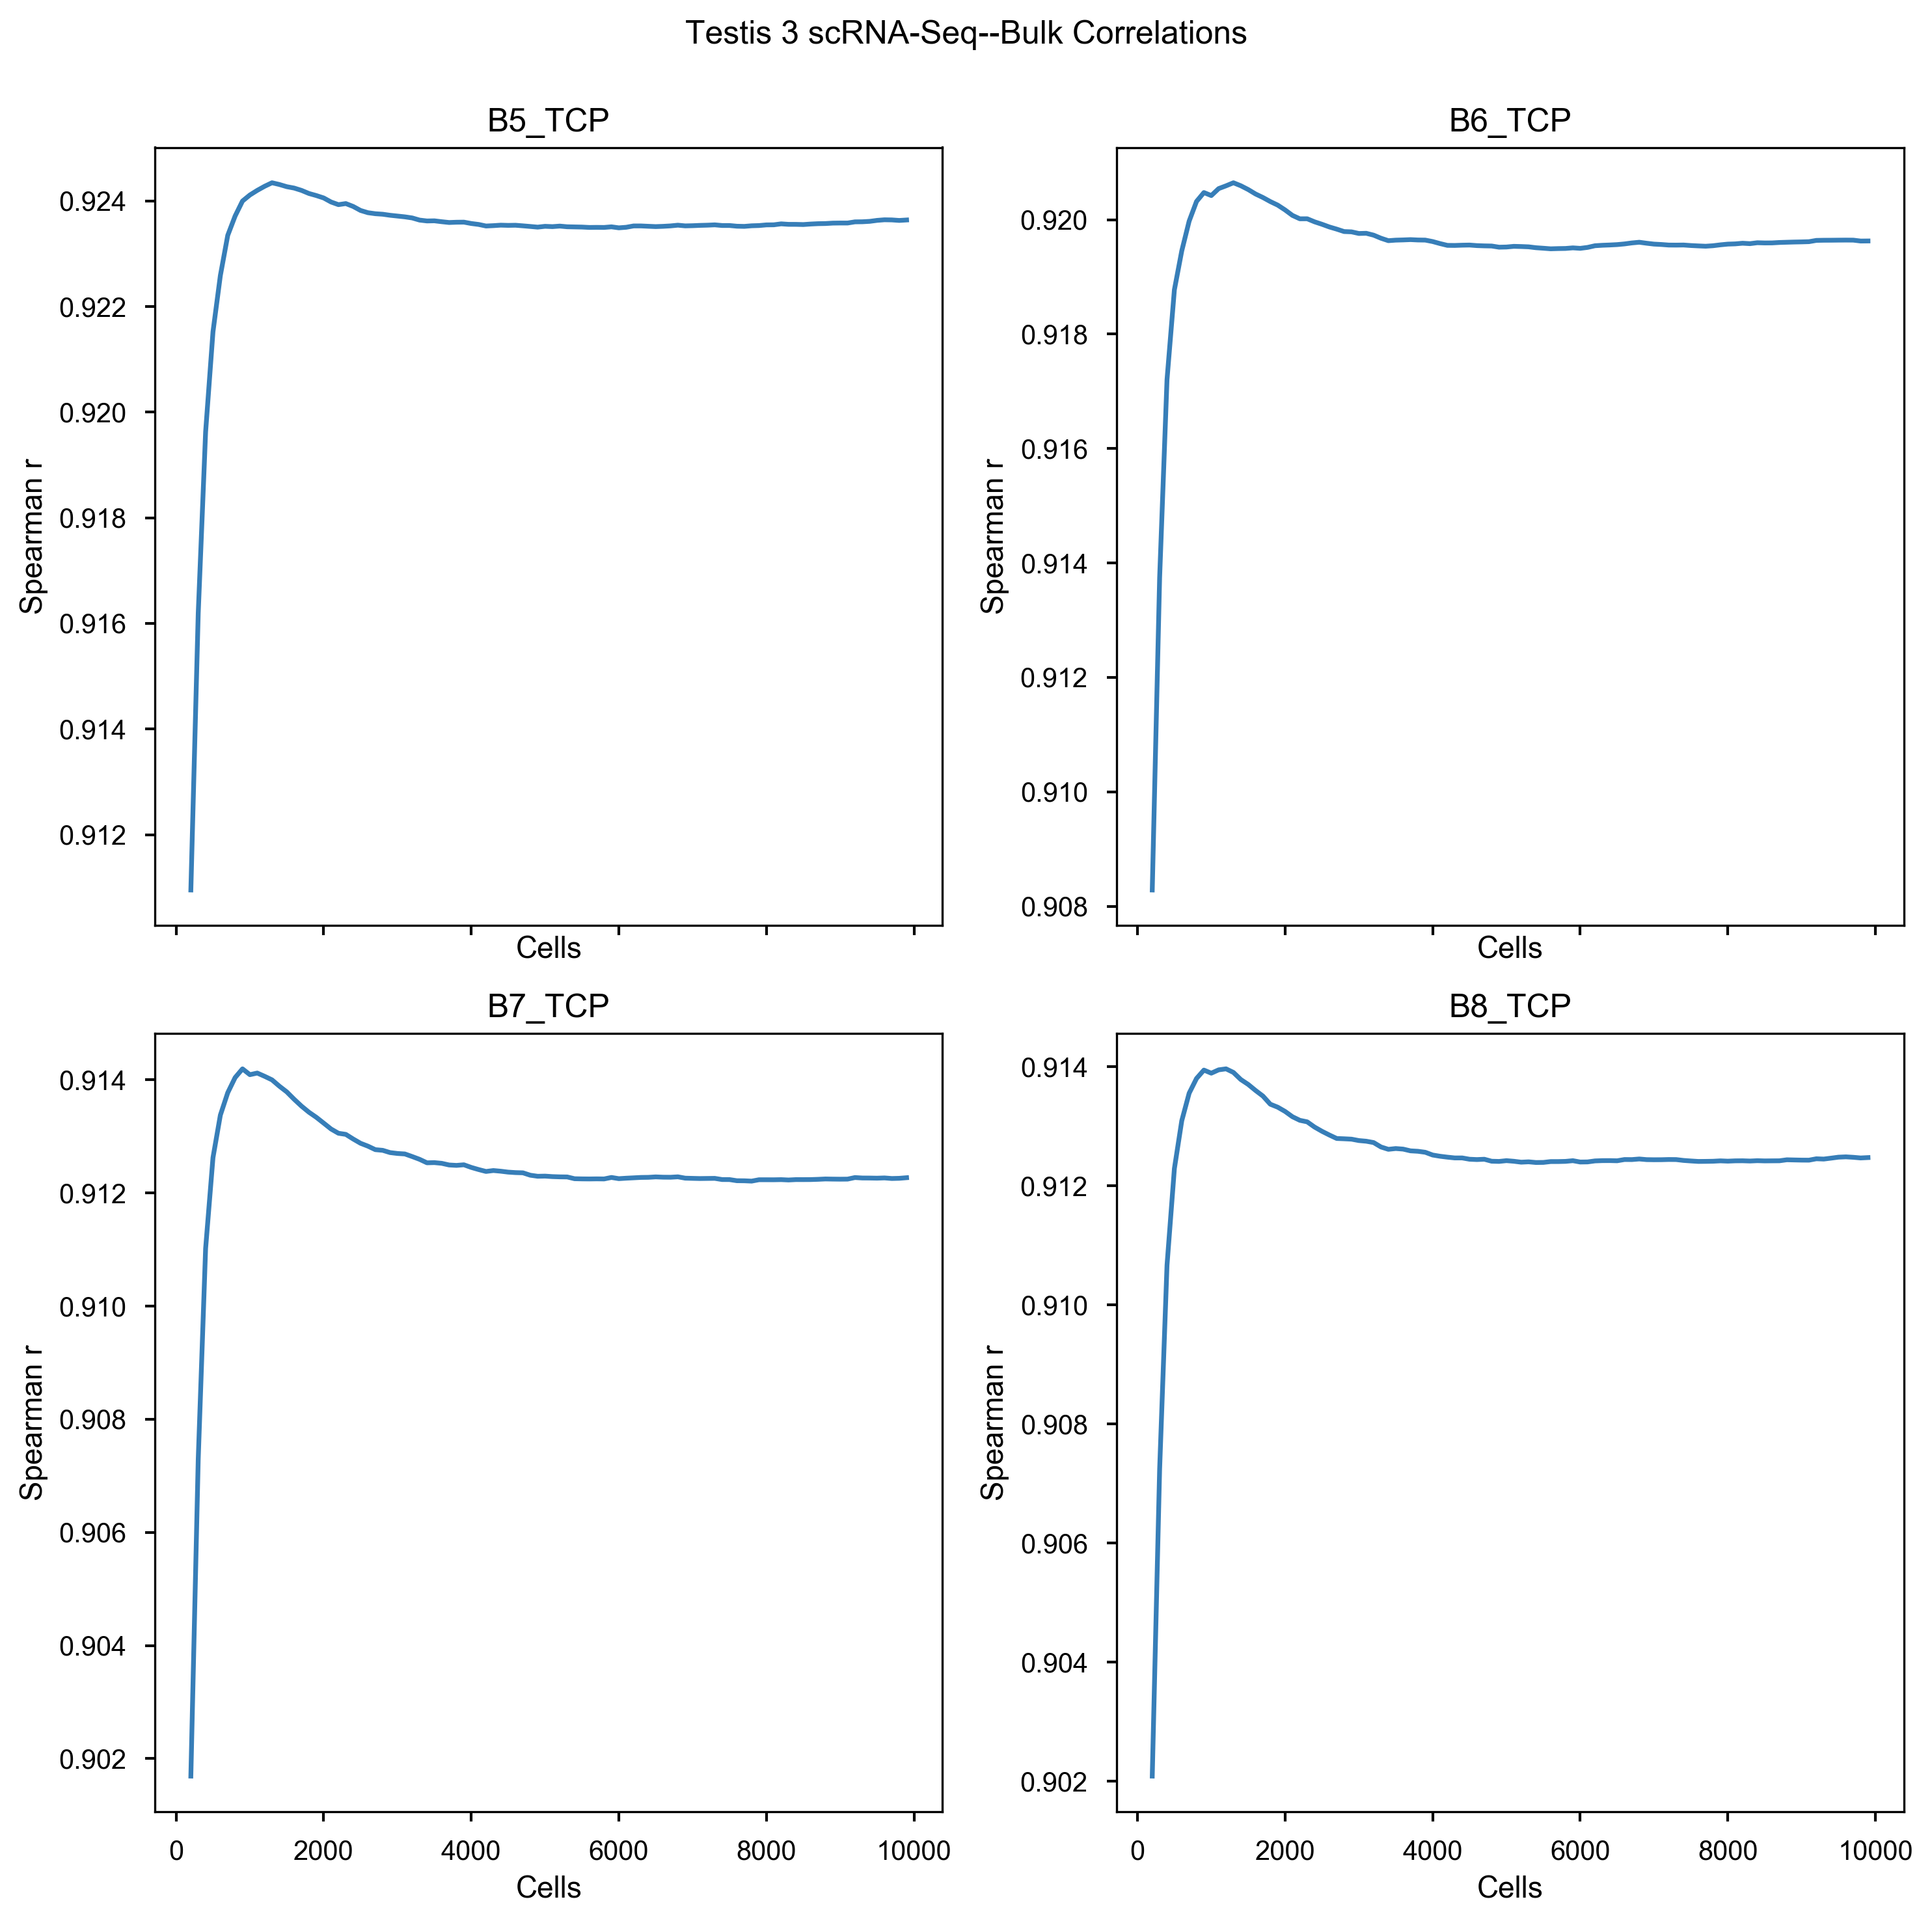

In [35]:
@make_figs(nbconfig.fig_name('testis3_bulk_corr'), styles=nbconfig.styles_full, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .95]})
def _plot():
    plot_corr_distribution(corr3)
    plt.suptitle('Testis 3 scRNA-Seq--Bulk Correlations')
    
_plot()

In [28]:
corr_summary = pd.concat([corr1.idxmax(), corr2.idxmax(), corr3.idxmax()], axis=1)
corr_summary.columns = ['Testis 1', 'Testis 2', 'Testis 3']

In [29]:
corr_summary

,Testis 1,Testis 2,Testis 3
B5_TCP,9900,1600,1300
B6_TCP,9900,1300,1300
B7_TCP,9900,1100,900
B8_TCP,9900,1300,1200


In [30]:
maxs = corr_summary.max()

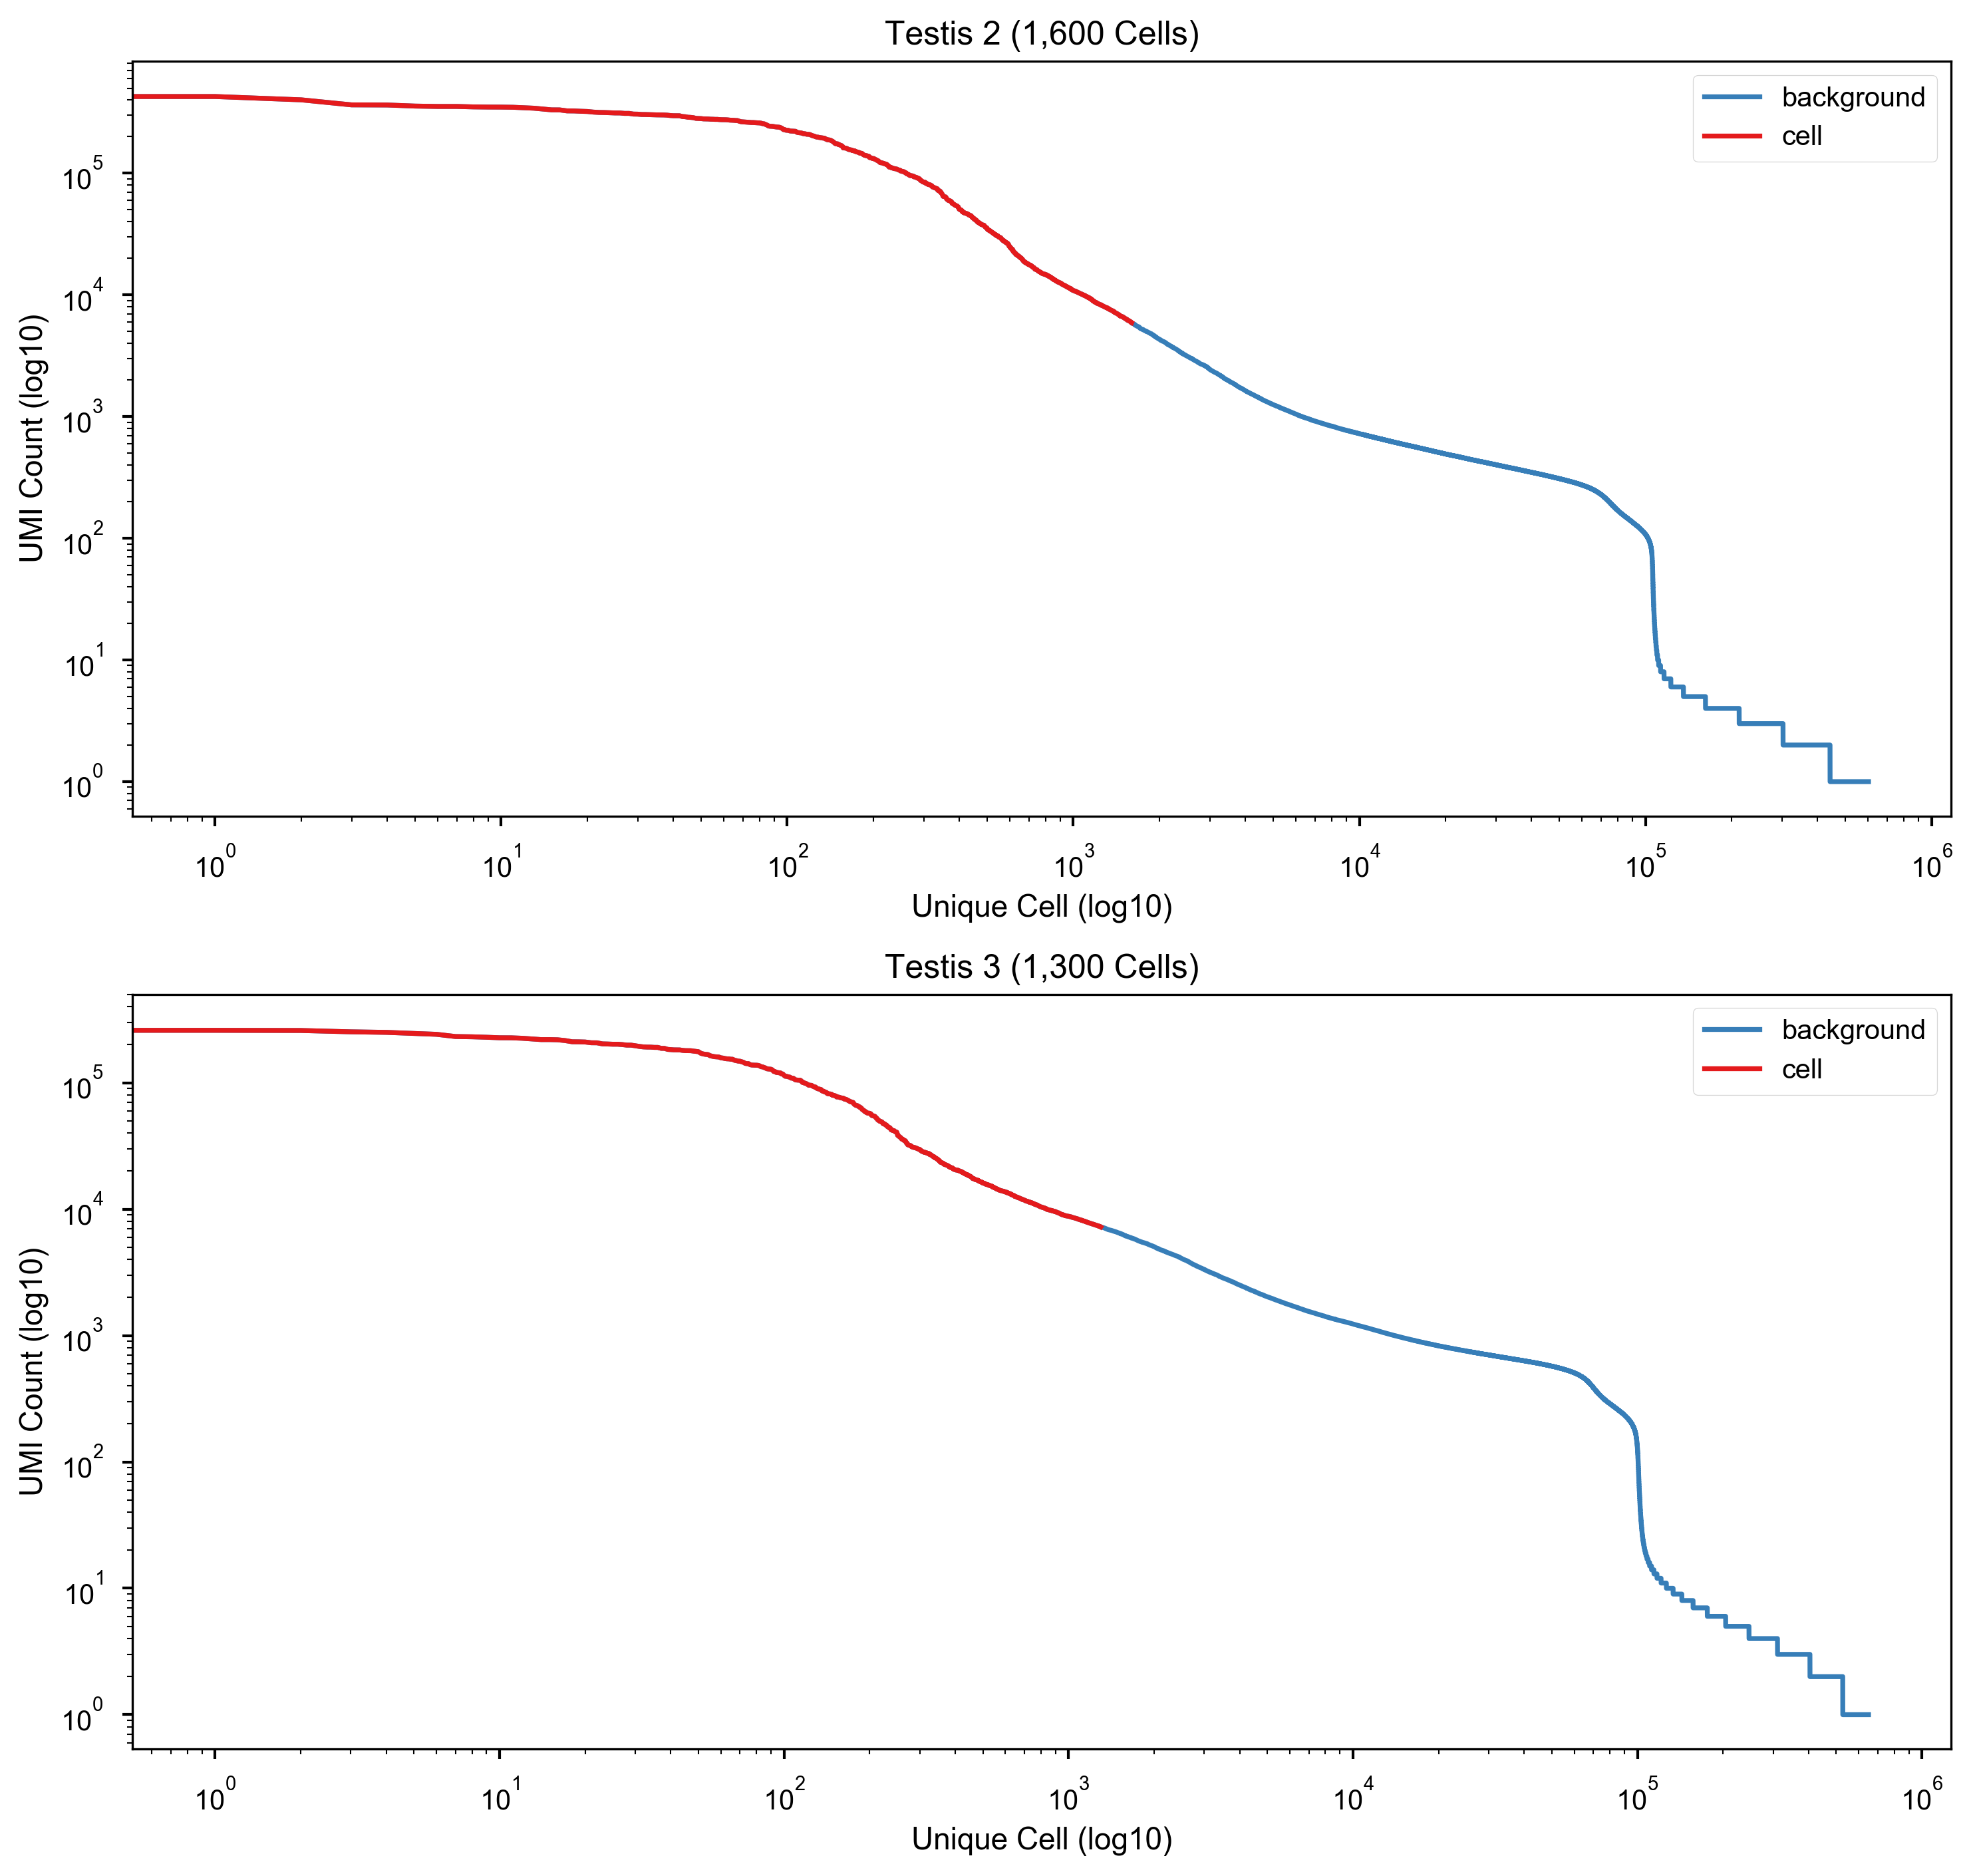

In [36]:
@make_figs(nbconfig.fig_name('testis2_3_barcode_rank'), styles=nbconfig.styles_full, formats=nbconfig.formats, kws_layout={'rect': [0, 0, 1, .95]})
def _plot():
    # Plot barcode rank plots showing the cutoffs
    fig, (ax1, ax2) = plt.subplots(2, 1)
    _max = maxs['Testis 2']
    plot_barcode_rank(umi2, umi2[:_max], ax=ax1)
    ax1.set_title(f'Testis 2 ({_max:,} Cells)')
    ax1.legend()

    _max = maxs['Testis 3']
    plot_barcode_rank(umi3, umi3[:_max], ax=ax2)
    ax2.set_title(f'Testis 3 ({_max:,} Cells)')
    ax2.legend()

_plot()

In [44]:
# Export datasets for use in downstream analysis.

## Export Testis1
_max = 1000
barcodes = umi1.index[:_max]
df = filter_gene_counts_by_barcode(barcodes, raw1)

fname = nbconfig.table_name('testis1_raw_counts.tsv')
df.to_csv(fname, sep='\t')

## Export Testis2
_max = maxs['Testis 2']
barcodes = umi2.index[:_max]
df = filter_gene_counts_by_barcode(barcodes, raw2)

fname = nbconfig.table_name('testis2_raw_counts.tsv')
df.to_csv(fname, sep='\t')

## Export Testis3
_max = maxs['Testis 3']
barcodes = umi3.index[:_max]
df = filter_gene_counts_by_barcode(barcodes, raw3)

fname = nbconfig.table_name('testis3_raw_counts.tsv')
df.to_csv(fname, sep='\t')